In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
train_dataset_path = "C:\\Users\\PC\\Desktop\\lisnen_data\\validation_data\\train"

In [3]:
val_dataset_path = "C:\\Users\\PC\\Desktop\\lisnen_data\\validation_data\\val"

In [9]:
test_dataset_path = "C:\\Users\\PC\\Desktop\\lisnen_data\\validation_data\\test"

In [5]:
IMG_WIDTH = 227
IMG_HEIGHT = 227
BATCH_SIZE = 32

# Data Augmentation

In [6]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 1504 images belonging to 4 classes.


In [7]:
valid_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

valid_generator = valid_datagen.flow_from_directory(val_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 186 images belonging to 4 classes.


In [10]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset_path,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 193 images belonging to 4 classes.


In [11]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classed present in the training and validation datasets\n")
for key,value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classed present in the training and validation datasets

0 : Baby_Cry
1 : Door_Bell
2 : Door_Knock
3 : Fire_Alarm


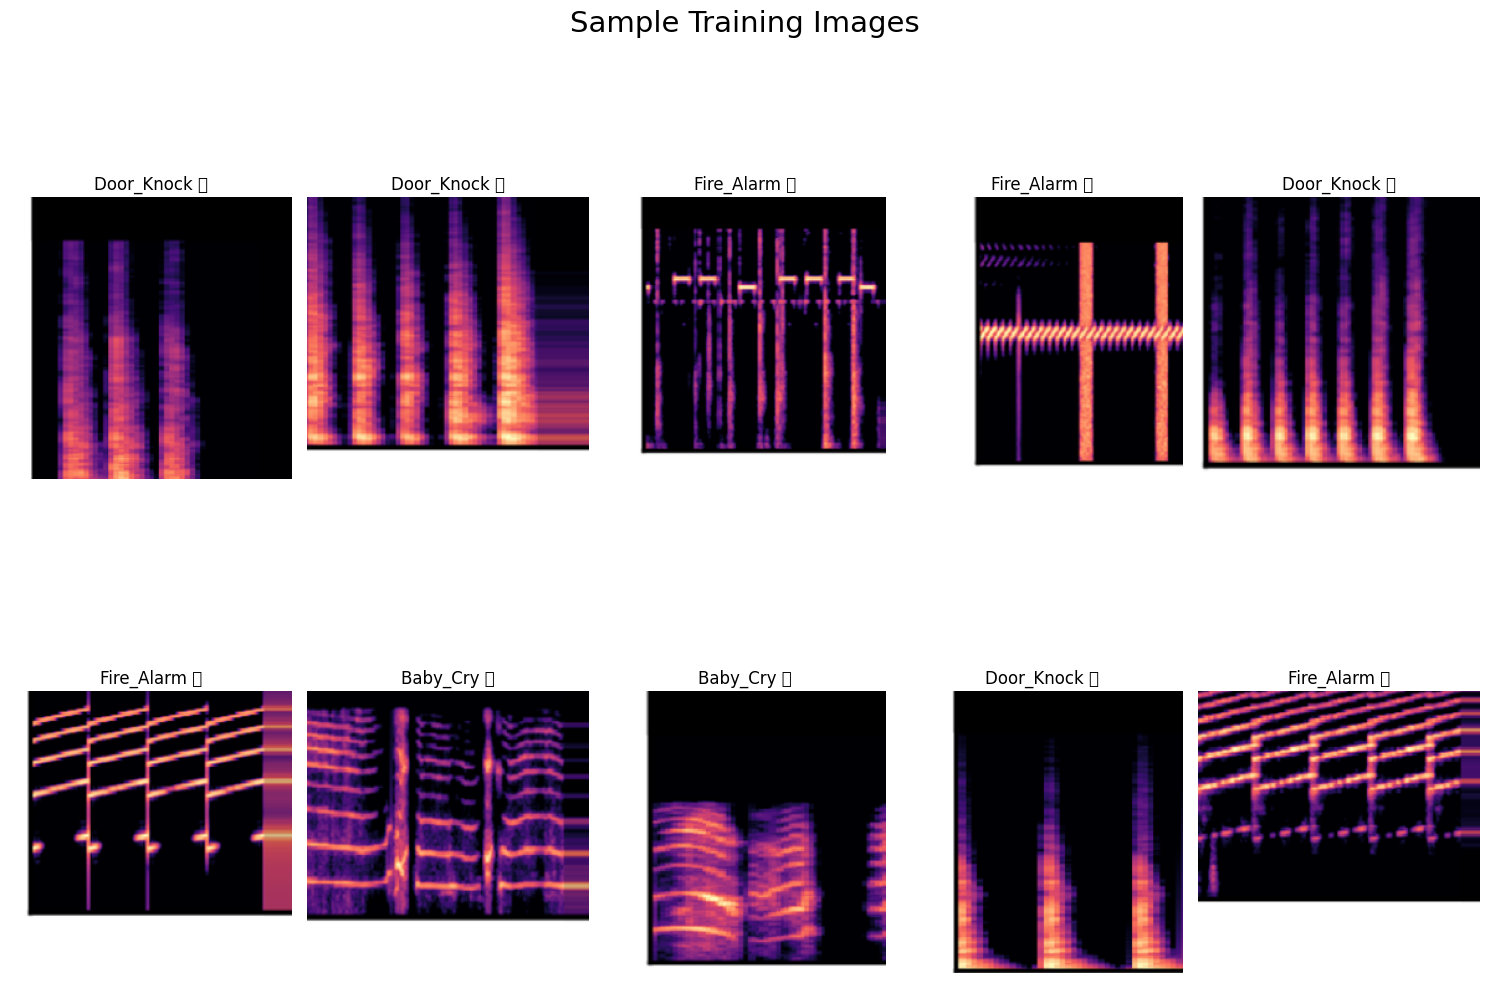

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15,12))
idx = 0
for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label} \t")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx +=1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [11]:
# from sklearn.model_selection import train_test_split
# import keras

# dcase_model = Sequential()
# dcase_model.add(Conv2D(16, 7, padding='same',input_shape=(IMG_WIDTH,IMG_HEIGHT,3)))  # X_train.shape[1] = No. of Columns
# dcase_model.add(BatchNormalization())
# dcase_model.add(Activation('relu'))
# dcase_model.add(Conv2D(16,7,padding='same'))
# dcase_model.add(BatchNormalization())
# dcase_model.add(Activation('relu'))
# dcase_model.add(MaxPooling2D(pool_size=(8,8)))
# dcase_model.add(Dropout(0.3))
# dcase_model.add(Conv2D(32,7,padding='same'))
# dcase_model.add(BatchNormalization())
# dcase_model.add(Activation('relu'))
# dcase_model.add(MaxPooling2D(pool_size=(4,4)))
# dcase_model.add(Dropout(0.3))
# dcase_model.add(Flatten())
# dcase_model.add(Dense(100,activation='relu'))
# dcase_model.add(Dropout(0.3))
# dcase_model.add(Dense(4))
# dcase_model.add(Activation('softmax'))
# # opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
# #opt = keras.optimizers.RMSprop(lr=0.001, decay=1e-6)
# dcase_model.summary()

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Bidirectional, GRU
from keras.layers import Flatten, Dense, Reshape

# Define the model
dcase_model = Sequential()

# Convolutional layers
dcase_model.add(Conv2D(64, (7, 7), strides=(2, 1), padding='same', activation='relu', input_shape=(IMG_WIDTH,IMG_HEIGHT,3)))
dcase_model.add(MaxPooling2D((3, 3), strides=(2, 2)))

dcase_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
dcase_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))

dcase_model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu'))
dcase_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

dcase_model.add(AveragePooling2D((1, 3), strides=(1, 2)))

dcase_model.add(Flatten())
dcase_model.add(Dense(128, activation='relu'))
dcase_model.add(Reshape((-1, 128)))

# Bi-GRU layer
dcase_model.add(Bidirectional(GRU(units=128, return_sequences=True)))

# Flatten and dense layers
dcase_model.add(Flatten())
dcase_model.add(Dense(128, activation='relu'))
dcase_model.add(Dense(4, activation='softmax'))

# Compile the model
dcase_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
dcase_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 114, 227, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 113, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 113, 64)       36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 113, 64)       36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 57, 128)       73856     
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 57, 128)       147584    
                                                        

In [14]:
import keras
opt = keras.optimizers.Adam(lr=0.0001)

In [15]:
from tensorflow.keras import metrics
dcase_model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])#,metrics.Precision(),metrics.Recall()])
dcase_model_history=dcase_model.fit(train_generator,
                                    batch_size=16,
                                    epochs=100,
                                    validation_data=valid_generator)
                                      #)

Epoch 1/100
47/47 [==============================] - 21s 267ms/step - loss: 1.2126 - accuracy: 0.4621 - val_loss: 0.8789 - val_accuracy: 0.7366
Epoch 2/100
47/47 [==============================] - 11s 241ms/step - loss: 0.8114 - accuracy: 0.6915 - val_loss: 0.6185 - val_accuracy: 0.7527
Epoch 3/100
47/47 [==============================] - 12s 245ms/step - loss: 0.6369 - accuracy: 0.7560 - val_loss: 0.6373 - val_accuracy: 0.7688
Epoch 4/100
47/47 [==============================] - 12s 251ms/step - loss: 0.5498 - accuracy: 0.7872 - val_loss: 0.4991 - val_accuracy: 0.7957
Epoch 5/100
47/47 [==============================] - 12s 245ms/step - loss: 0.5031 - accuracy: 0.8019 - val_loss: 0.5045 - val_accuracy: 0.7903
Epoch 6/100
47/47 [==============================] - 11s 239ms/step - loss: 0.4818 - accuracy: 0.8045 - val_loss: 0.4815 - val_accuracy: 0.7957
Epoch 7/100
47/47 [==============================] - 11s 242ms/step - loss: 0.4377 - accuracy: 0.8371 - val_loss: 0.4656 - val_accuracy:

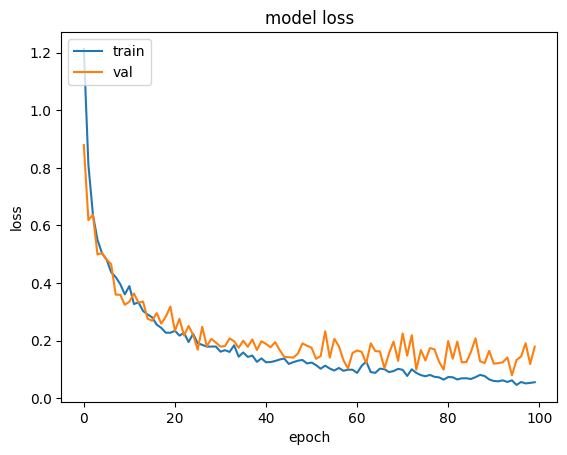

In [16]:
plt.plot(dcase_model_history.history['loss'])
plt.plot(dcase_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

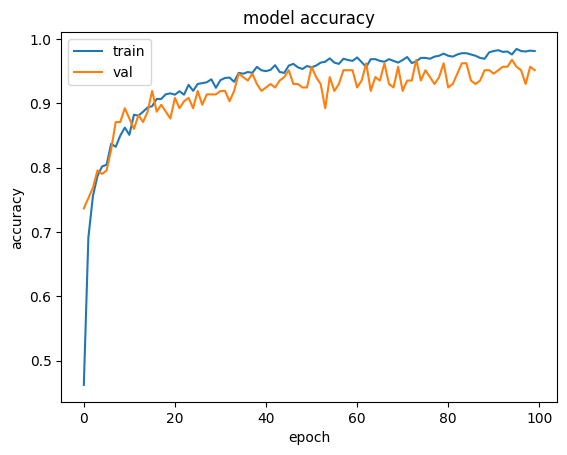

In [17]:
plt.plot(dcase_model_history.history['accuracy'])
plt.plot(dcase_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
predictions = dcase_model.predict(test_generator)

7/7 [==============================] - 2s 173ms/step


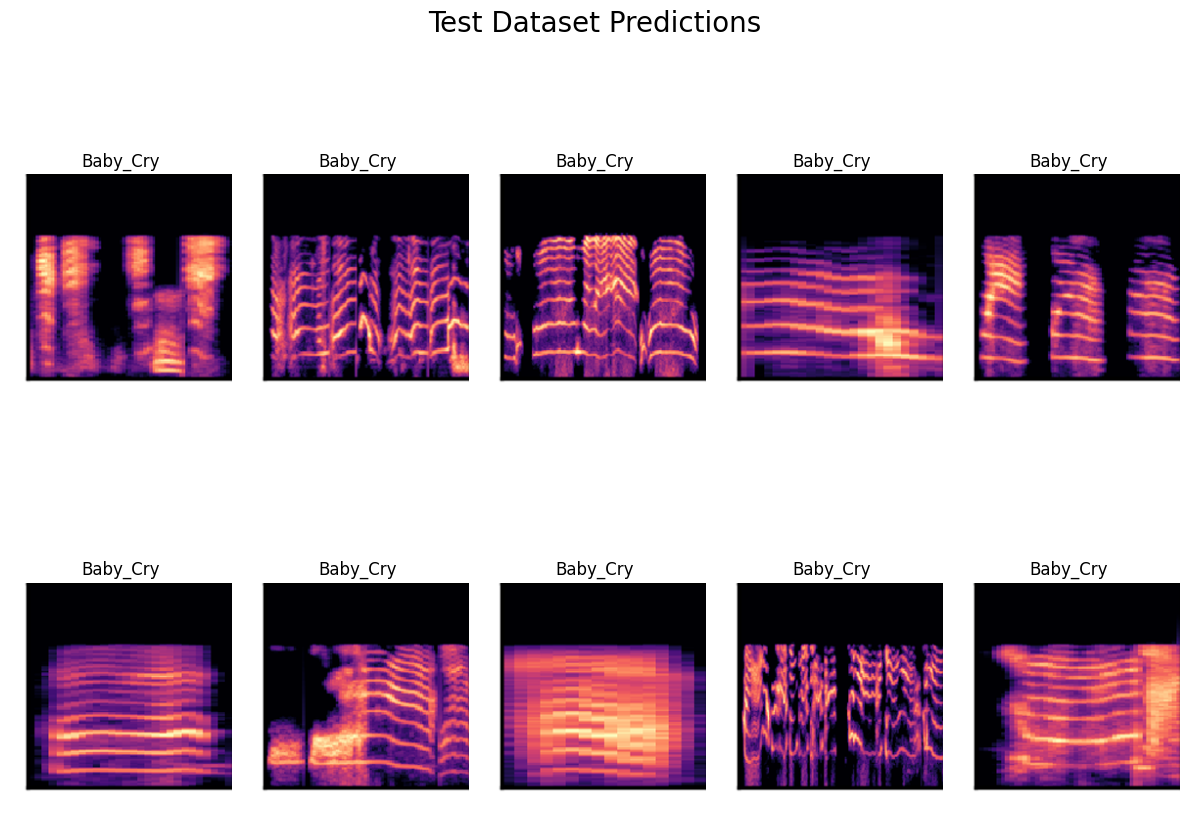

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [20]:
test_loss, test_accuracy = dcase_model.evaluate(test_generator, batch_size=BATCH_SIZE)

7/7 [==============================] - 1s 36ms/step - loss: 0.0557 - accuracy: 0.9793


In [21]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.05569518357515335
Test Accuracy: 0.9792746305465698


# Confusion Matrix

In [22]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

In [22]:
# cf_mtx = confusion_matrix(y_true, y_pred)

# group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
# box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
# box_labels = np.asarray(box_labels).reshape(6, 6)

# plt.figure(figsize = (12, 10))
# sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
#            cmap="YlGnBu", fmt="", annot=box_labels)
# plt.xlabel('Predicted Classes')
# plt.ylabel('True Classes')
# plt.show()

In [23]:
print(classification_report(y_true, y_pred, target_names=labels.values()))


              precision    recall  f1-score   support

    Baby_Cry       0.98      1.00      0.99        62
   Door_Bell       1.00      0.93      0.97        30
  Door_Knock       0.96      1.00      0.98        49
  Fire_Alarm       0.98      0.96      0.97        52

    accuracy                           0.98       193
   macro avg       0.98      0.97      0.98       193
weighted avg       0.98      0.98      0.98       193



# Wrong Predictions

In [24]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [25]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

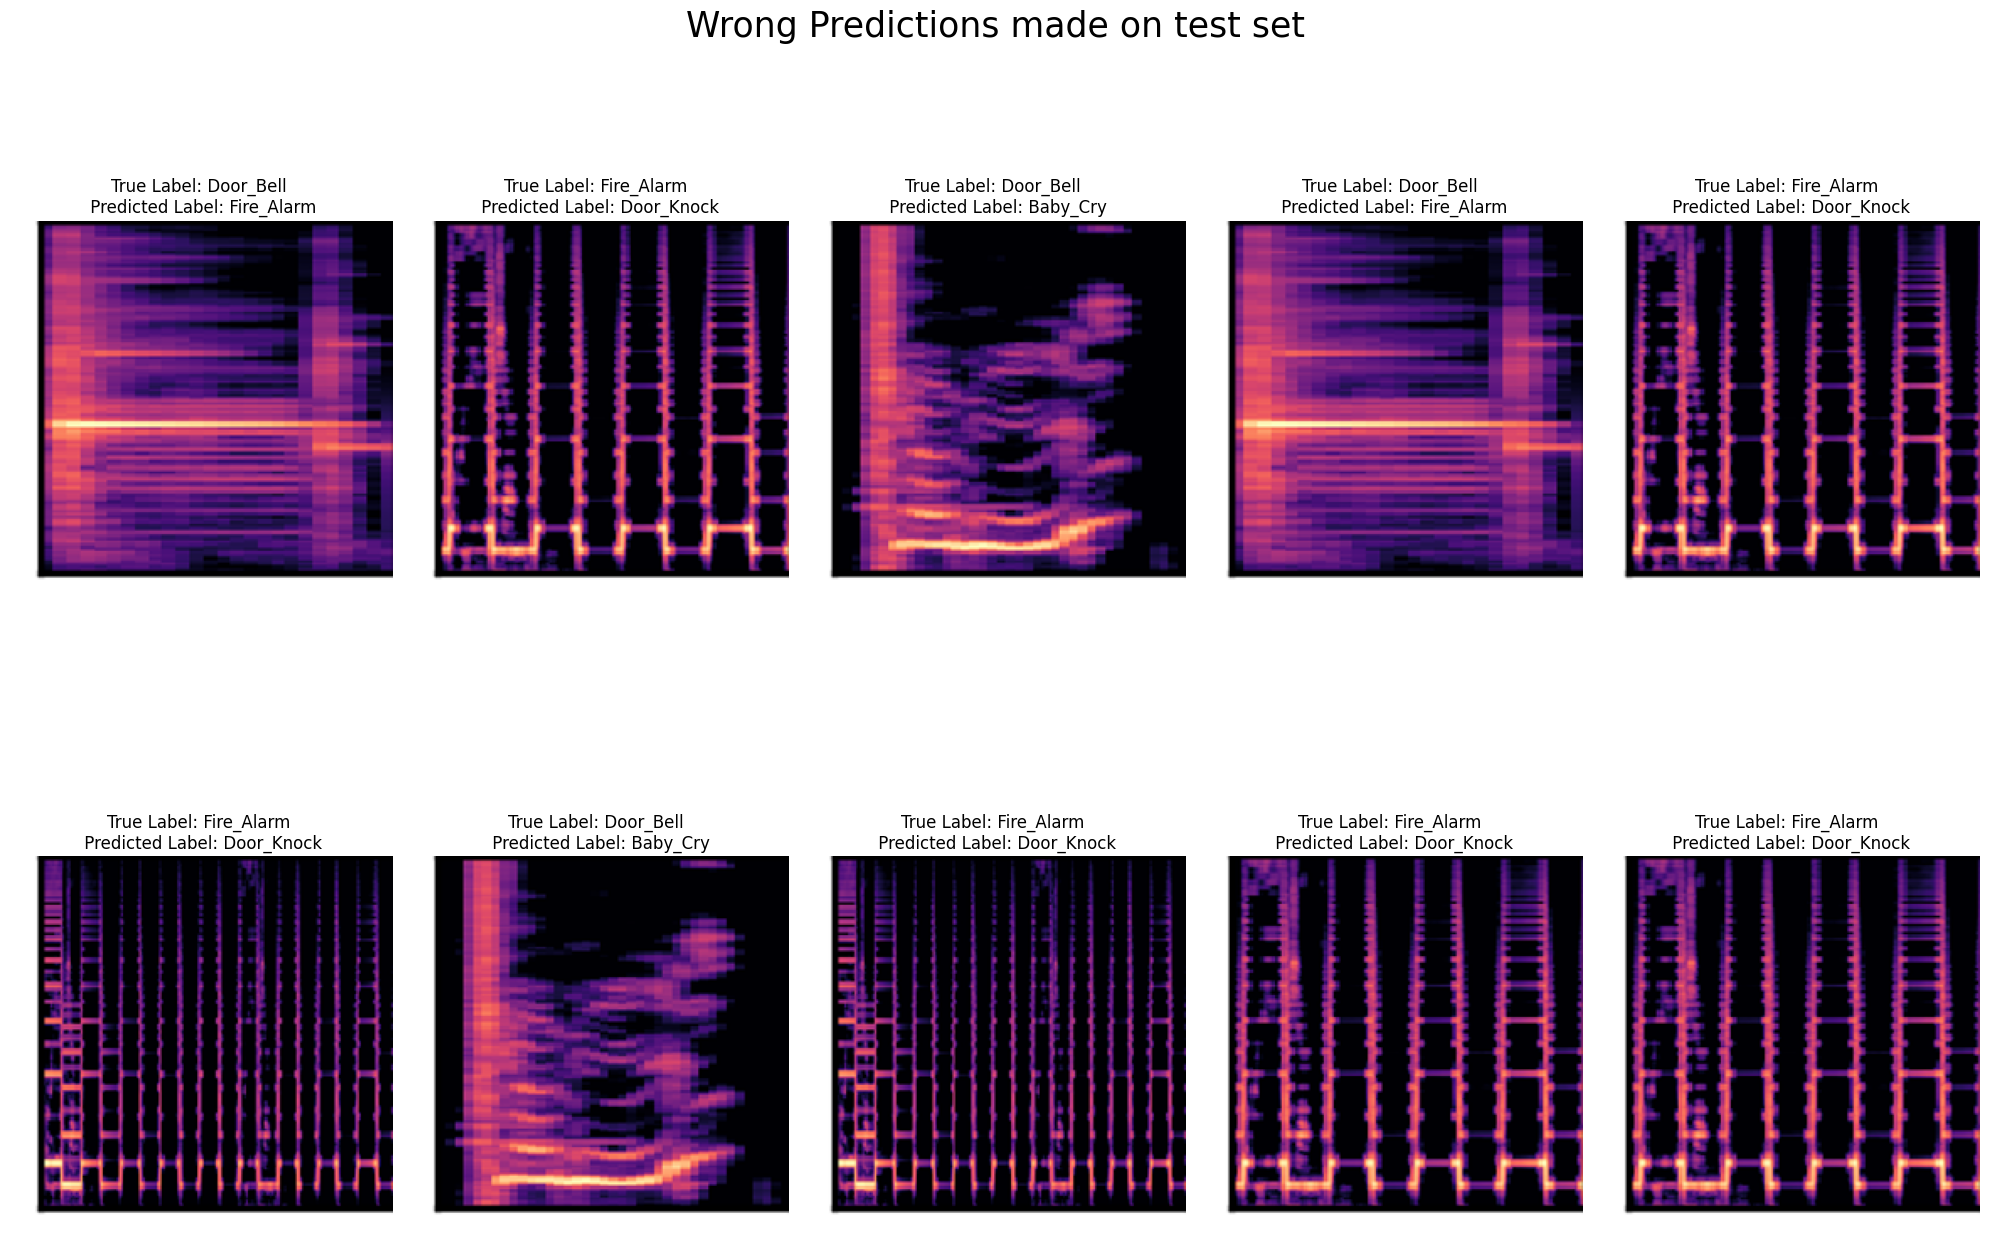

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 15))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset_path, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=25)
plt.show()

# Change file Names using Python

In [27]:
#Baby Cry Test files renaming
# import os

# count = 1
# folder_path = "/Users/pranayrajsarap/Spoken Language Processing/December_2021/lisnen_segmented_working_data/test/Baby_Cry_Melspectrograms"

# for file in os.listdir(folder_path):
#     # Check if the file is a regular file (not a directory)
#     if os.path.isfile(os.path.join(folder_path, file)):
#         # Create the new file name with the count prefix
#         new_name = f'btest-{count}.png'
#         # Join the folder path with the file name to get full paths
#         old_path = os.path.join(folder_path, file)
#         new_path = os.path.join(folder_path, new_name)
#         # Rename the file
#         os.rename(old_path, new_path)
#         # Increment count for the next file
#         count += 1

# Door Knock Test files renaming

# import os

# count = 1
# folder_path = "/Users/pranayrajsarap/Spoken Language Processing/December_2021/lisnen_segmented_working_data/test/Door_Knock_Melspectrograms"

# for file in os.listdir(folder_path):
#     # Check if the file is a regular file (not a directory)
#     if os.path.isfile(os.path.join(folder_path, file)):
#         # Create the new file name with the count prefix
#         new_name = f'dktest-{count}.png'
#         # Join the folder path with the file name to get full paths
#         old_path = os.path.join(folder_path, file)
#         new_path = os.path.join(folder_path, new_name)
#         # Rename the file
#         os.rename(old_path, new_path)
#         # Increment count for the next file
#         count += 1

# Door bell Test files renaming
# import os

# count = 1
# folder_path = "/Users/pranayrajsarap/Spoken Language Processing/December_2021/lisnen_segmented_working_data/test/Door_Bell_Melspectrograms"

# for file in os.listdir(folder_path):
#     # Check if the file is a regular file (not a directory)
#     if os.path.isfile(os.path.join(folder_path, file)):
#         # Create the new file name with the count prefix
#         new_name = f'dbtest-{count}.png'
#         # Join the folder path with the file name to get full paths
#         old_path = os.path.join(folder_path, file)
#         new_path = os.path.join(folder_path, new_name)
#         # Rename the file
#         os.rename(old_path, new_path)
#         # Increment count for the next file
#         count += 1

# Fire Alarm Test files remaining
# import os

# count = 1
# folder_path = "/Users/pranayrajsarap/Spoken Language Processing/December_2021/lisnen_segmented_working_data/test/Fire_Alarm_Melspectrograms"

# for file in os.listdir(folder_path):
#     # Check if the file is a regular file (not a directory)
#     if os.path.isfile(os.path.join(folder_path, file)):
#         # Create the new file name with the count prefix
#         new_name = f'fatest-{count}.png'
#         # Join the folder path with the file name to get full paths
#         old_path = os.path.join(folder_path, file)
#         new_path = os.path.join(folder_path, new_name)
#         # Rename the file
#         os.rename(old_path, new_path)
#         # Increment count for the next file
#         count += 1


# Split images into train test validation

In [29]:
# import splitfolders
# splitfolders.ratio(train_dataset_path, output="/Users/pranayrajsarap/Spoken Language Processing/December_2021/lisnen_segmented_working_data/validation_data", seed=1337, ratio=(.8, 0.1,0.1))